# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.269951390800136 -2.6495541147104222
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [19]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    #Qs_labels = targetQs[1:]
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [20]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [23]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR.ckpt')

Episode:0 meanR:38.0000 rate:0.0760 gloss:0.0536 dloss:0.6953 dlossR:0.6953 dlossQ:0.6931
Episode:1 meanR:67.5000 rate:0.1940 gloss:0.0974 dloss:0.6789 dlossR:0.6789 dlossQ:0.6951
Episode:2 meanR:77.3333 rate:0.1940 gloss:0.0895 dloss:0.6759 dlossR:0.6759 dlossQ:0.6955
Episode:3 meanR:103.5000 rate:0.3640 gloss:0.1972 dloss:0.6854 dlossR:0.6854 dlossQ:0.6981
Episode:4 meanR:105.6000 rate:0.2280 gloss:0.0878 dloss:0.6693 dlossR:0.6693 dlossQ:0.6973
Episode:5 meanR:107.5000 rate:0.2340 gloss:-0.0017 dloss:0.6397 dlossR:0.6397 dlossQ:0.6976
Episode:6 meanR:111.2857 rate:0.2680 gloss:0.0919 dloss:0.6667 dlossR:0.6667 dlossQ:0.6995
Episode:7 meanR:104.8750 rate:0.1200 gloss:-0.0078 dloss:0.6449 dlossR:0.6449 dlossQ:0.6951
Episode:8 meanR:121.0000 rate:0.5000 gloss:0.2110 dloss:0.6964 dlossR:0.6964 dlossQ:0.7099
Episode:9 meanR:117.1000 rate:0.1640 gloss:-0.0669 dloss:0.6119 dlossR:0.6119 dlossQ:0.6946
Episode:10 meanR:117.7273 rate:0.2480 gloss:0.0062 dloss:0.6409 dlossR:0.6409 dlossQ:0.700

Episode:94 meanR:68.2105 rate:0.0900 gloss:-1.1610 dloss:0.3155 dlossR:0.3155 dlossQ:0.4510
Episode:95 meanR:67.9271 rate:0.0820 gloss:-1.6263 dloss:0.3319 dlossR:0.3319 dlossQ:0.4309
Episode:96 meanR:67.6907 rate:0.0900 gloss:-1.1525 dloss:0.3148 dlossR:0.3148 dlossQ:0.4491
Episode:97 meanR:67.3265 rate:0.0640 gloss:-1.1588 dloss:0.2678 dlossR:0.2678 dlossQ:0.4526
Episode:98 meanR:67.0909 rate:0.0880 gloss:-1.1535 dloss:0.3105 dlossR:0.3105 dlossQ:0.4430
Episode:99 meanR:66.8400 rate:0.0840 gloss:-1.1881 dloss:0.3006 dlossR:0.3006 dlossQ:0.4327
Episode:100 meanR:66.9700 rate:0.1020 gloss:-1.2283 dloss:0.3328 dlossR:0.3328 dlossQ:0.4233
Episode:101 meanR:66.3400 rate:0.0680 gloss:-1.2590 dloss:0.2648 dlossR:0.2648 dlossQ:0.4135
Episode:102 meanR:65.9000 rate:0.1060 gloss:-1.2966 dloss:0.3392 dlossR:0.3392 dlossQ:0.4023
Episode:103 meanR:64.3400 rate:0.0520 gloss:-1.3201 dloss:0.2282 dlossR:0.2282 dlossQ:0.4112
Episode:104 meanR:63.4800 rate:0.0560 gloss:-1.3371 dloss:0.2345 dlossR:0.23

Episode:187 meanR:43.4900 rate:0.1020 gloss:-0.9548 dloss:0.3568 dlossR:0.3568 dlossQ:0.5118
Episode:188 meanR:44.4500 rate:0.2160 gloss:-0.9004 dloss:0.5287 dlossR:0.5287 dlossQ:0.5266
Episode:189 meanR:47.8400 rate:0.6960 gloss:-0.6145 dloss:1.3029 dlossR:1.3029 dlossQ:0.6521
Episode:190 meanR:52.7400 rate:1.0000 gloss:-0.3736 dloss:1.7508 dlossR:1.7508 dlossQ:0.7690
Episode:191 meanR:57.5500 rate:1.0000 gloss:-0.3629 dloss:1.7385 dlossR:1.7385 dlossQ:0.7711
Episode:192 meanR:57.9500 rate:0.1200 gloss:-1.1964 dloss:0.3868 dlossR:0.3868 dlossQ:0.4436
Episode:193 meanR:58.2300 rate:0.1100 gloss:-1.2784 dloss:0.3785 dlossR:0.3785 dlossQ:0.4402
Episode:194 meanR:57.8900 rate:0.0220 gloss:-0.8966 dloss:0.2446 dlossR:0.2446 dlossQ:0.5388
Episode:195 meanR:57.5800 rate:0.0200 gloss:-0.8666 dloss:0.2485 dlossR:0.2485 dlossQ:0.5529
Episode:196 meanR:57.2400 rate:0.0220 gloss:-0.9237 dloss:0.2394 dlossR:0.2394 dlossQ:0.5375
Episode:197 meanR:57.0900 rate:0.0340 gloss:-0.8106 dloss:0.2874 dloss

Episode:277 meanR:86.9200 rate:0.0380 gloss:-1.0285 dloss:0.2449 dlossR:0.2449 dlossQ:0.4902
Episode:278 meanR:86.9700 rate:0.0360 gloss:-1.0871 dloss:0.2314 dlossR:0.2314 dlossQ:0.4796
Episode:279 meanR:87.2500 rate:0.0820 gloss:-1.1016 dloss:0.3089 dlossR:0.3089 dlossQ:0.4662
Episode:280 meanR:87.3000 rate:0.0320 gloss:-1.2212 dloss:0.2026 dlossR:0.2026 dlossQ:0.4426
Episode:281 meanR:87.3200 rate:0.0260 gloss:-1.2649 dloss:0.1850 dlossR:0.1850 dlossQ:0.4422
Episode:282 meanR:87.7400 rate:0.1140 gloss:-1.2091 dloss:0.3621 dlossR:0.3621 dlossQ:0.4371
Episode:283 meanR:87.8000 rate:0.0400 gloss:-1.3684 dloss:0.2029 dlossR:0.2029 dlossQ:0.3996
Episode:284 meanR:87.7400 rate:0.0280 gloss:-1.4950 dloss:0.1671 dlossR:0.1671 dlossQ:0.3896
Episode:285 meanR:88.1500 rate:0.1200 gloss:-1.3927 dloss:0.3788 dlossR:0.3788 dlossQ:0.3879
Episode:286 meanR:88.1800 rate:0.0260 gloss:-1.5897 dloss:0.1530 dlossR:0.1530 dlossQ:0.3679
Episode:287 meanR:87.7800 rate:0.0220 gloss:-1.6682 dloss:0.1387 dloss

Episode:366 meanR:55.2000 rate:0.0900 gloss:-1.2335 dloss:0.3141 dlossR:0.3141 dlossQ:0.4298
Episode:367 meanR:55.2300 rate:0.0840 gloss:-1.2223 dloss:0.3037 dlossR:0.3037 dlossQ:0.4403
Episode:368 meanR:55.2400 rate:0.1000 gloss:-1.2749 dloss:0.3335 dlossR:0.3335 dlossQ:0.4216
Episode:369 meanR:55.3900 rate:0.0840 gloss:-1.2472 dloss:0.3032 dlossR:0.3032 dlossQ:0.4326
Episode:370 meanR:55.6100 rate:0.0900 gloss:-1.2639 dloss:0.3151 dlossR:0.3151 dlossQ:0.4330
Episode:371 meanR:55.9000 rate:0.1120 gloss:-1.2916 dloss:0.3560 dlossR:0.3560 dlossQ:0.4176
Episode:372 meanR:56.3900 rate:0.1760 gloss:-1.1937 dloss:0.4799 dlossR:0.4799 dlossQ:0.4420
Episode:373 meanR:57.6100 rate:0.2900 gloss:-1.0188 dloss:0.6870 dlossR:0.6870 dlossQ:0.4981
Episode:374 meanR:59.3000 rate:0.3720 gloss:-0.9153 dloss:0.8161 dlossR:0.8161 dlossQ:0.5317
Episode:375 meanR:60.9000 rate:0.3600 gloss:-0.8508 dloss:0.7755 dlossR:0.7755 dlossQ:0.5505
Episode:376 meanR:62.9900 rate:0.4540 gloss:-0.7535 dloss:0.9142 dloss

Episode:455 meanR:91.6300 rate:0.2720 gloss:-1.0406 dloss:0.6502 dlossR:0.6502 dlossQ:0.4907
Episode:456 meanR:92.4300 rate:0.1820 gloss:-1.2141 dloss:0.5043 dlossR:0.5043 dlossQ:0.4521
Episode:457 meanR:92.9600 rate:0.2360 gloss:-1.1057 dloss:0.5886 dlossR:0.5886 dlossQ:0.4635
Episode:458 meanR:94.2700 rate:0.3160 gloss:-1.0319 dloss:0.7343 dlossR:0.7343 dlossQ:0.4892
Episode:459 meanR:95.4300 rate:0.2900 gloss:-1.1468 dloss:0.7144 dlossR:0.7144 dlossQ:0.4575
Episode:460 meanR:96.5600 rate:0.2740 gloss:-1.2562 dloss:0.7087 dlossR:0.7087 dlossQ:0.4245
Episode:461 meanR:97.4500 rate:0.3020 gloss:-1.1181 dloss:0.7345 dlossR:0.7345 dlossQ:0.4687
Episode:462 meanR:98.0600 rate:0.1800 gloss:-1.0982 dloss:0.4857 dlossR:0.4857 dlossQ:0.4697
Episode:463 meanR:97.4000 rate:0.2100 gloss:-1.1138 dloss:0.5466 dlossR:0.5466 dlossQ:0.4641
Episode:464 meanR:96.5000 rate:0.0940 gloss:-1.1529 dloss:0.3371 dlossR:0.3371 dlossQ:0.4581
Episode:465 meanR:96.1900 rate:0.0960 gloss:-1.1485 dloss:0.3407 dloss

Episode:553 meanR:70.9400 rate:0.5700 gloss:-1.0537 dloss:1.3260 dlossR:1.3260 dlossQ:0.5040
Episode:554 meanR:71.1500 rate:0.2680 gloss:-1.3056 dloss:0.7031 dlossR:0.7031 dlossQ:0.4189
Episode:555 meanR:70.3300 rate:0.1080 gloss:-1.1292 dloss:0.3544 dlossR:0.3544 dlossQ:0.4607
Episode:556 meanR:69.7200 rate:0.0600 gloss:-1.2532 dloss:0.2540 dlossR:0.2540 dlossQ:0.4278
Episode:557 meanR:68.8000 rate:0.0520 gloss:-1.3700 dloss:0.2272 dlossR:0.2272 dlossQ:0.3920
Episode:558 meanR:67.4800 rate:0.0520 gloss:-1.4223 dloss:0.2227 dlossR:0.2227 dlossQ:0.3873
Episode:559 meanR:66.2000 rate:0.0340 gloss:-1.5069 dloss:0.1762 dlossR:0.1762 dlossQ:0.3617
Episode:560 meanR:64.9700 rate:0.0280 gloss:-1.5691 dloss:0.1567 dlossR:0.1567 dlossQ:0.3647
Episode:561 meanR:63.6300 rate:0.0340 gloss:-1.6872 dloss:0.1658 dlossR:0.1658 dlossQ:0.3368
Episode:562 meanR:62.9300 rate:0.0400 gloss:-1.6899 dloss:0.1811 dlossR:0.1811 dlossQ:0.3183
Episode:563 meanR:62.0300 rate:0.0300 gloss:-1.6869 dloss:0.1546 dloss

Episode:645 meanR:37.9600 rate:0.1540 gloss:-1.6111 dloss:0.4682 dlossR:0.4682 dlossQ:0.3187
Episode:646 meanR:38.7500 rate:0.1860 gloss:-1.5183 dloss:0.5371 dlossR:0.5371 dlossQ:0.3374
Episode:647 meanR:39.4300 rate:0.1760 gloss:-1.5427 dloss:0.5158 dlossR:0.5158 dlossQ:0.3313
Episode:648 meanR:41.0200 rate:0.3440 gloss:-1.1995 dloss:0.8424 dlossR:0.8424 dlossQ:0.4377
Episode:649 meanR:40.9900 rate:0.0260 gloss:-1.9115 dloss:0.1319 dlossR:0.1319 dlossQ:0.3198
Episode:650 meanR:40.9000 rate:0.0260 gloss:-1.8781 dloss:0.1332 dlossR:0.1332 dlossQ:0.3239
Episode:651 meanR:40.9000 rate:0.0320 gloss:-1.8445 dloss:0.1534 dlossR:0.1534 dlossQ:0.3287
Episode:652 meanR:41.0400 rate:0.0480 gloss:-1.7754 dloss:0.2011 dlossR:0.2011 dlossQ:0.3193
Episode:653 meanR:38.4200 rate:0.0460 gloss:-1.7239 dloss:0.1972 dlossR:0.1972 dlossQ:0.3382
Episode:654 meanR:37.6100 rate:0.1060 gloss:-1.6287 dloss:0.3545 dlossR:0.3545 dlossQ:0.3358
Episode:655 meanR:37.3100 rate:0.0480 gloss:-1.7788 dloss:0.2077 dloss

Episode:735 meanR:79.0400 rate:0.3740 gloss:-0.5131 dloss:0.7034 dlossR:0.7034 dlossQ:0.6470
Episode:736 meanR:79.8400 rate:0.2220 gloss:-0.6192 dloss:0.5318 dlossR:0.5318 dlossQ:0.6112
Episode:737 meanR:80.8500 rate:0.2600 gloss:-0.5859 dloss:0.5746 dlossR:0.5746 dlossQ:0.6210
Episode:738 meanR:81.8500 rate:0.2500 gloss:-0.5861 dloss:0.5632 dlossR:0.5632 dlossQ:0.6208
Episode:739 meanR:82.2200 rate:0.1400 gloss:-0.6700 dloss:0.4390 dlossR:0.4390 dlossQ:0.5942
Episode:740 meanR:82.5000 rate:0.1200 gloss:-0.6875 dloss:0.4153 dlossR:0.4153 dlossQ:0.5889
Episode:741 meanR:83.0100 rate:0.1600 gloss:-0.6707 dloss:0.4603 dlossR:0.4603 dlossQ:0.5952
Episode:742 meanR:83.3000 rate:0.1340 gloss:-0.7006 dloss:0.4286 dlossR:0.4286 dlossQ:0.5882
Episode:743 meanR:83.4400 rate:0.1260 gloss:-0.7106 dloss:0.4186 dlossR:0.4186 dlossQ:0.5848
Episode:744 meanR:83.4400 rate:0.1180 gloss:-0.7404 dloss:0.4048 dlossR:0.4048 dlossQ:0.5762
Episode:745 meanR:83.2200 rate:0.1100 gloss:-0.7553 dloss:0.3936 dloss

Episode:823 meanR:182.4000 rate:0.9600 gloss:0.7279 dloss:0.6723 dlossR:0.6723 dlossQ:0.6638
Episode:824 meanR:185.0400 rate:0.7080 gloss:0.6263 dloss:0.6844 dlossR:0.6844 dlossQ:0.6426
Episode:825 meanR:187.5900 rate:0.6500 gloss:0.6675 dloss:0.6842 dlossR:0.6842 dlossQ:0.6231
Episode:826 meanR:190.8200 rate:0.7320 gloss:0.6599 dloss:0.6779 dlossR:0.6779 dlossQ:0.6359
Episode:827 meanR:195.0700 rate:1.0000 gloss:0.6940 dloss:0.6944 dlossR:0.6944 dlossQ:0.6924
Episode:828 meanR:199.3300 rate:1.0000 gloss:0.6839 dloss:0.7064 dlossR:0.7064 dlossQ:0.6933
Episode:829 meanR:202.3100 rate:0.6740 gloss:0.7886 dloss:0.6748 dlossR:0.6748 dlossQ:0.5886
Episode:830 meanR:207.2100 rate:1.0000 gloss:0.7804 dloss:0.6354 dlossR:0.6354 dlossQ:0.6613
Episode:831 meanR:210.2300 rate:0.6220 gloss:0.9071 dloss:0.7029 dlossR:0.7029 dlossQ:0.5457
Episode:832 meanR:213.5700 rate:1.0000 gloss:0.7830 dloss:0.6332 dlossR:0.6332 dlossQ:0.6598
Episode:833 meanR:218.4700 rate:1.0000 gloss:0.9172 dloss:0.5470 dloss

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Success rates')

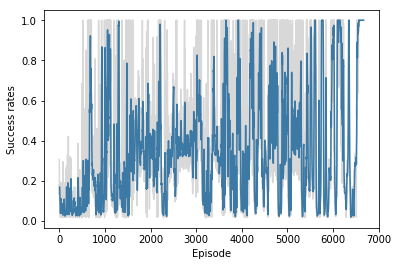

In [32]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

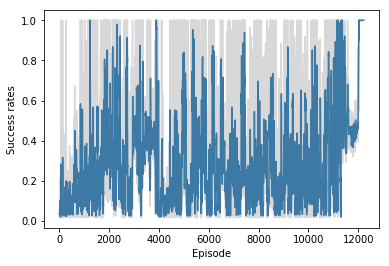

In [28]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

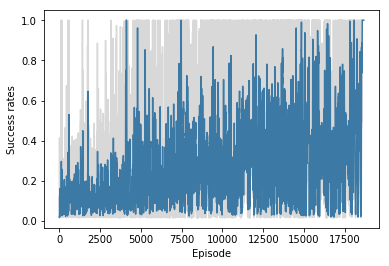

In [110]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

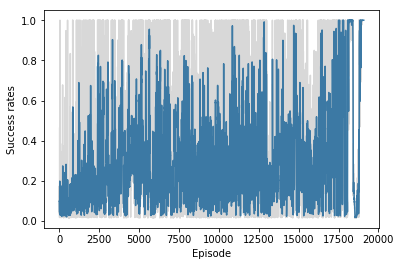

In [106]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

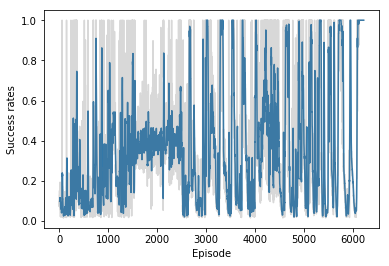

In [98]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

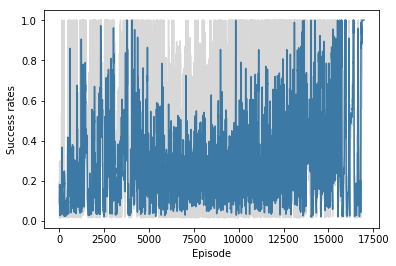

In [94]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

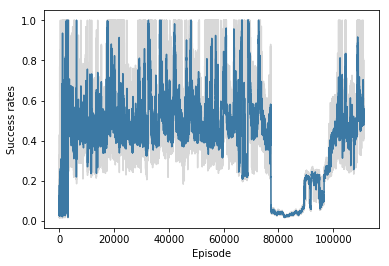

In [91]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

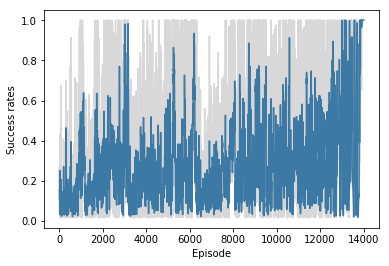

In [78]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

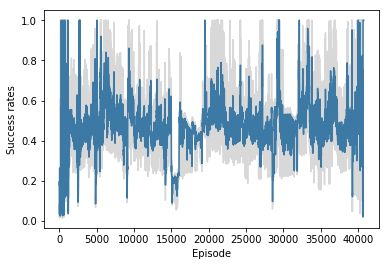

In [59]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

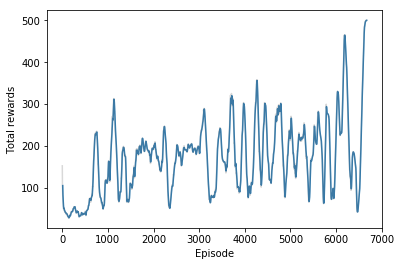

In [33]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

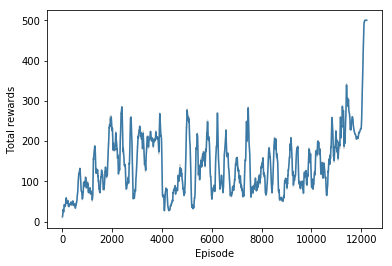

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

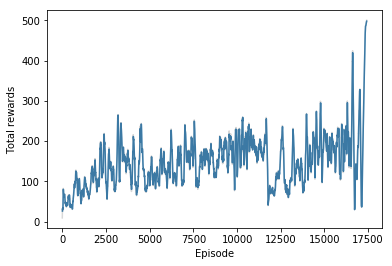

In [113]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

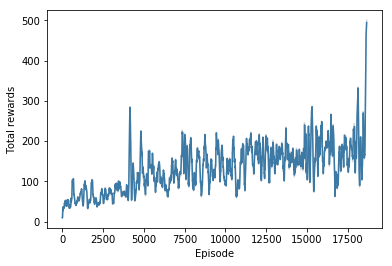

In [111]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

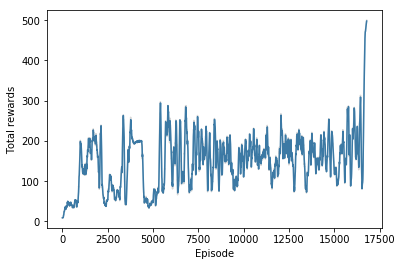

In [108]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

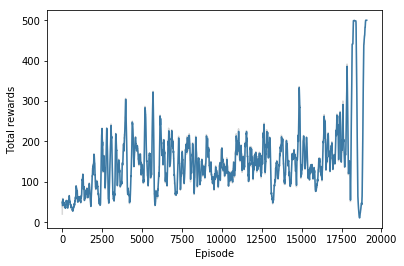

In [105]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

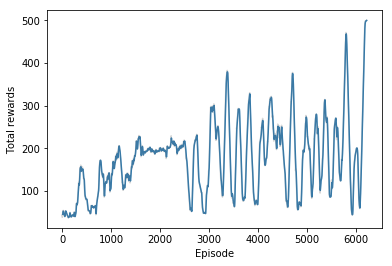

In [102]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

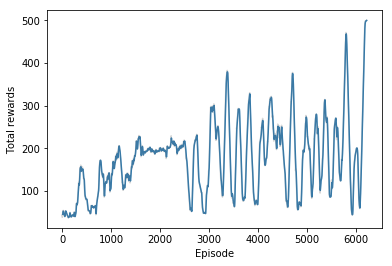

In [101]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

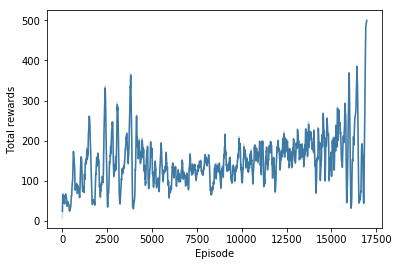

In [95]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

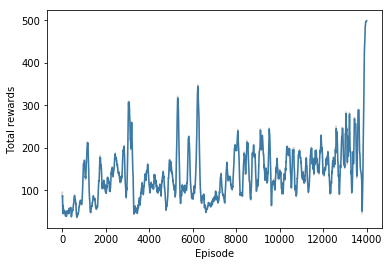

In [72]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

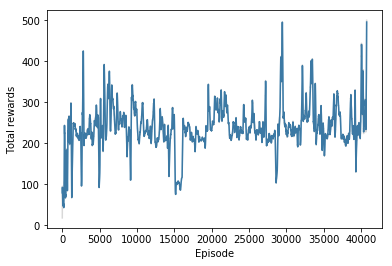

In [54]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

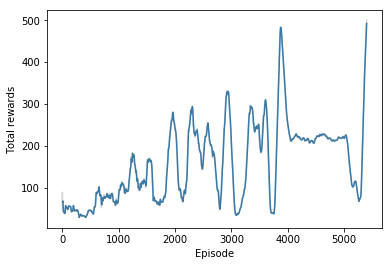

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

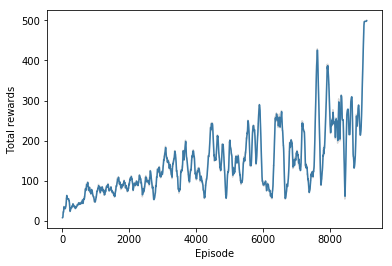

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

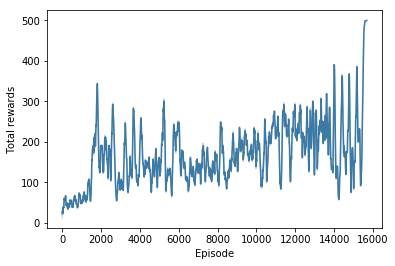

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

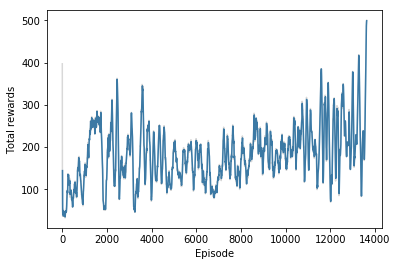

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

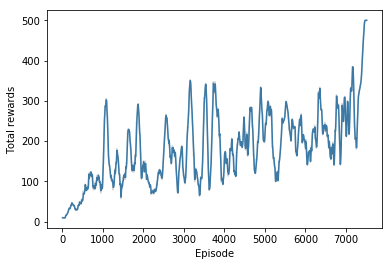

Text(0,0.5,'G losses')

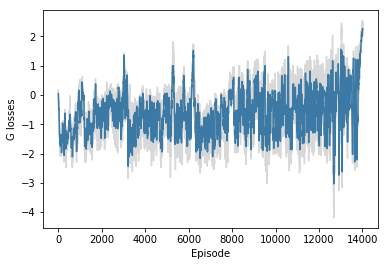

In [73]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

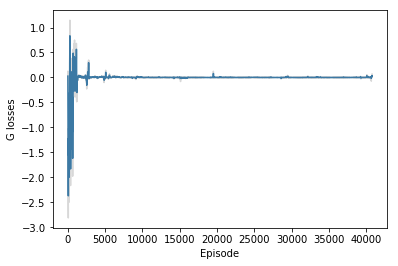

In [55]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

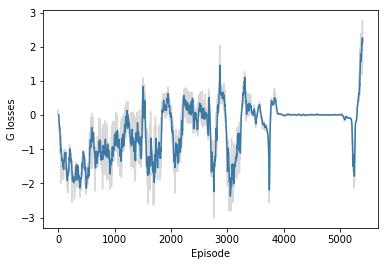

In [28]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

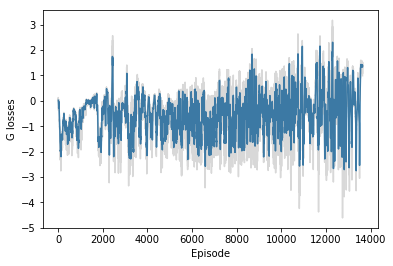

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

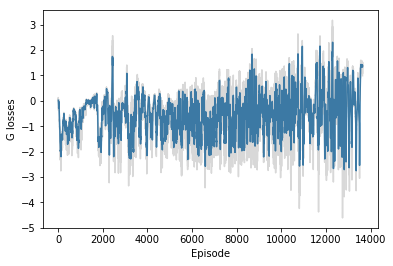

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

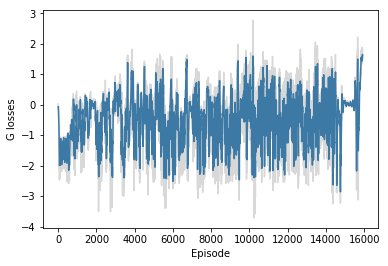
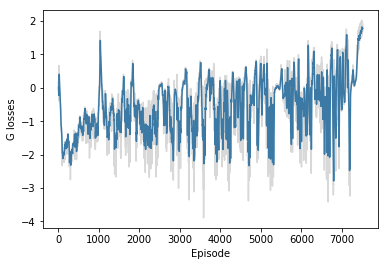

Text(0,0.5,'D losses')

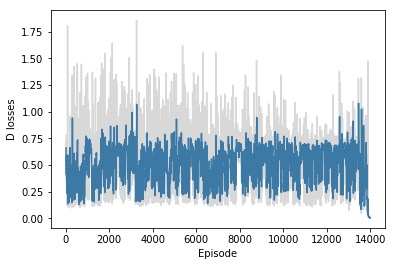

In [74]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

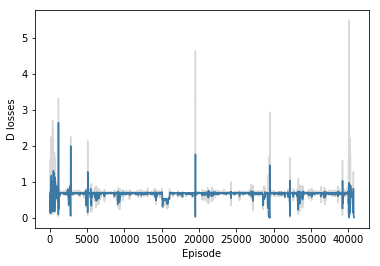

In [56]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

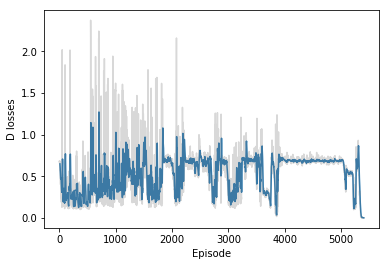

In [29]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

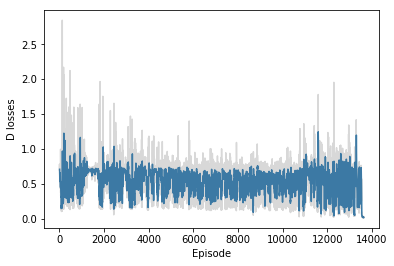

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

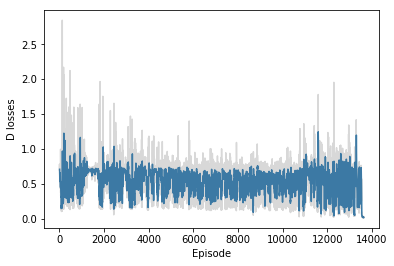

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

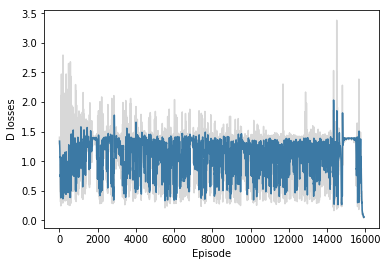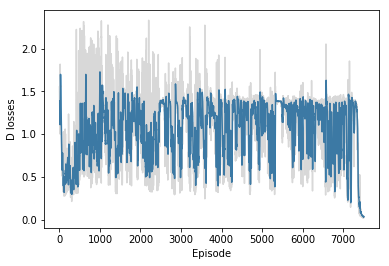

Text(0,0.5,'D losses R')

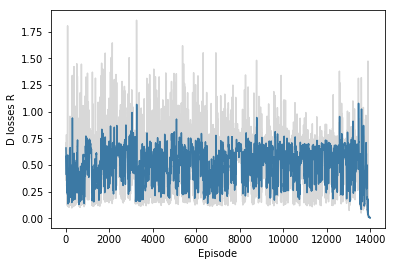

In [75]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

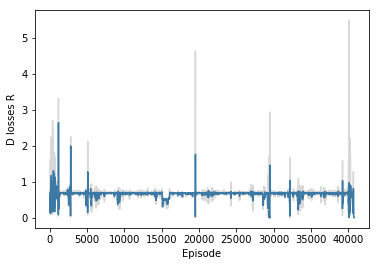

In [57]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

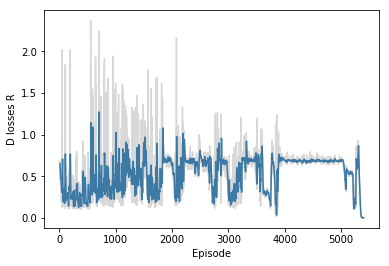

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

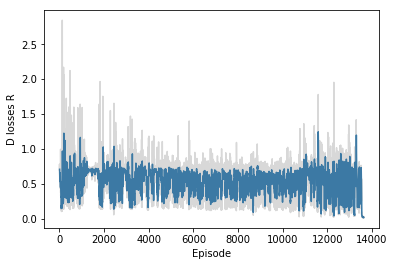

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

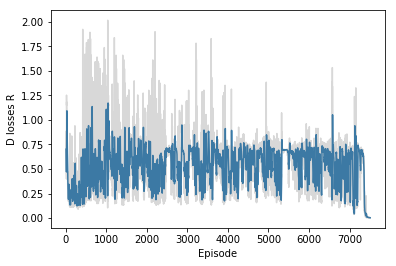

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

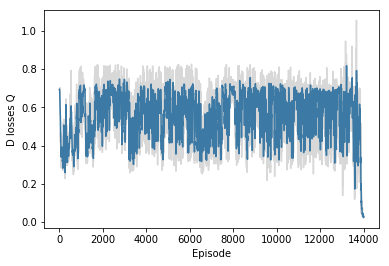

In [76]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

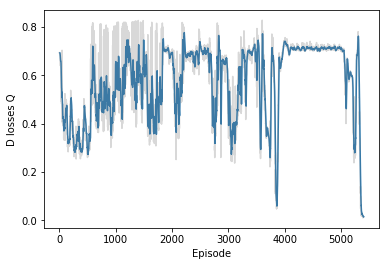

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

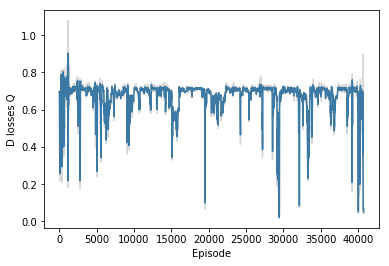

In [58]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

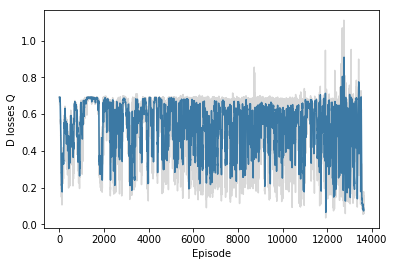

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

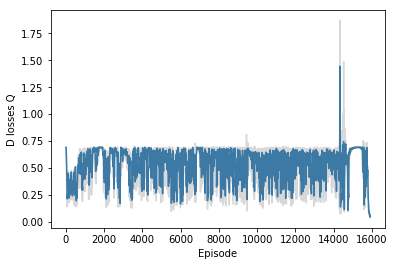

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

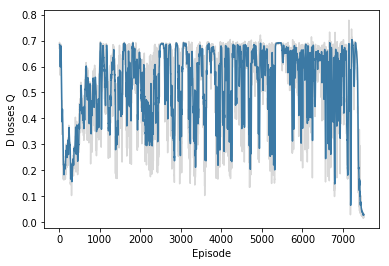

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.